# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle

# magic word for producing visualizations in notebook
%matplotlib inline


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
#from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score


SEED = 42


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
def load_data():
    azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=',')
    customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=',')

    attributes_desc = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1, engine = 'openpyxl')
    return azdias, customers, attributes_desc

In [6]:
# load in the data

azdias, customers, attributes_desc = load_data()

c:\users\kirchjna\anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [7]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [8]:
azdias.shape

(891221, 366)

In [9]:
customers.shape

(191652, 369)

# 0.1 Clean the dataframes

All things discussed in this part is done in the function - clean_dataframe

In [3]:
def clean_dataframe(df, rel_cols, missing_keys_dict, test_df = False):
    '''    
    Input:
    df - Dataframe to be cleaned
    rel_cols - cols to be kept
    test_df - bool - False: rows with high nans will be dropped
                     True: no rows will be dropped
    
    Output
    df_clean - cleaned Dataframe
    '''
    
    df_clean= df[rel_cols] 
    
    df_clean = unkown_to_nan(df_clean, missing_keys_dict)
    
    # Convert cols 'EINGEFUEGT_AM', 'OST_WEST_KZ', "CAMEO_DEU_2015"
    df_clean['EINGEFUEGT_AM'] = pd.to_datetime(df_clean['EINGEFUEGT_AM'], format='%Y-%m-%d ').dt.year
    
    df_clean['OST_WEST_KZ'] = df_clean['OST_WEST_KZ'].replace('O', 0).replace('W', 1)
    
    df_clean['CAMEO_DEU_2015'] = df_clean['CAMEO_DEU_2015'].str.replace("A", "1").str.replace("B", "2").str.replace("C", "3")
    df_clean['CAMEO_DEU_2015'] = df_clean['CAMEO_DEU_2015'].str.replace("D", "4").str.replace("E", "5").str.replace("F","6")

    df_clean['CAMEO_DEU_2015'] = df_clean['CAMEO_DEU_2015'].astype(float).astype(pd.Int32Dtype())
    df_clean['CAMEO_DEUG_2015'] = df_clean['CAMEO_DEUG_2015'].astype(float).astype(pd.Int32Dtype())
    df_clean['CAMEO_INTL_2015'] = df_clean['CAMEO_INTL_2015'].astype(float).astype(pd.Int32Dtype())
    
    # Drop rows with more than 20 missing values despite of test dataframe
    if test_df == False:
        df_clean = df_clean[df_clean.isnull().sum(axis=1) <= 20]
    
    
    # Print new shape
    print(f"Old shape: {df.shape}")
    print(f"New shape: {df_clean.shape}")
    
    return df_clean
    

## 0.1.1 Convert unkown - keys to np.nan

In the Excel- Sheet DIAS Attributes is the description for the keys in the different columns. <br>
For example the column "BIP_FLAG" has the following keys: <br>
-1	unknown <br>
0	no company in the building <br>
1	company in the building <br>

So the value -1 should be replaced with np.nan. For other attributes the unkown values have different flags, f.e. 0, "X", "XX". These values are all converted to np.nan




In [10]:
def create_missing_keys_dict():
    '''
    INPUT: -
    OUTPUT: dictionary with columns as keys and the flags for unkown values as values
    '''
    #Load DIAS Attributes Excel and filter for unkown meanings
    attr_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', usecols='B:E', dtype='str', engine = 'openpyxl', skiprows = 1)
    missing_keys = attr_values[attr_values["Meaning"].isin(["unknown","unknown / no main age detectable"])]
    
    # Create dict of missing attribute-value combinations
    missing_keys_dict = {}
    for index, row in missing_keys.iterrows():
        key = row["Attribute"]
        missing_keys_dict[key] = row["Value"].split(", ")


    # Some missing values aren't described in the DIAS Attributes Excel
    missing_keys_dict["CAMEO_INTL_2015"] = ['XX']
    
    missing_keys_dict["CAMEO_DEUG_2015"] = ['X']
    missing_keys_dict["CAMEO_DEU_2015"] =['XX']
    missing_keys_dict["GEBURTSJAHR"] = ["0"]

    # Some Columns don't fit to the name in the excel
    missing_keys_dict["KBA13_CCM_1401_2500"] = missing_keys_dict["KBA13_CCM_1400_2500"]
    missing_keys_dict["KBA13_BAUMAX"] = missing_keys_dict["KBA05_BAUMAX"]
    missing_keys_dict["KBA13_ANTG1"] =  missing_keys_dict["KBA05_ANTG1"]
    missing_keys_dict["KBA13_ANTG2"] =  missing_keys_dict["KBA05_ANTG2"]
    missing_keys_dict["KBA13_ANTG3"] =  missing_keys_dict["KBA05_ANTG3"]
    missing_keys_dict["KBA13_ANTG4"] =  missing_keys_dict["KBA05_ANTG4"]
    
    return missing_keys_dict

In [2]:
def unkown_to_nan(df, missing_keys_dict):
    '''
    Some columns have keys that stand for unkown values. These values are replaced with np.nan. So that the nan-data can handled
    appropriate (f.e. in drop nan columns and rows)
    
    Input:
    df - Dataframe to clean
    missing_keys_dict - dictionary with keys for unkown values -> nan values
    
    Outout:
    df_clean - Dataframe with cleaned keys
    '''
    df_clean = df.copy()
    for col in df.columns:
        try:
            for key in missing_keys_dict[col]:
                if "X" in key:
                    df_clean[col] = df_clean[col].replace(key, np.nan)
                else:

                    df_clean[col] = df_clean[col].replace(int(key), np.nan)
        except Exception:
            pass
        
    return df_clean

In [11]:
# Create the missing_keys_dict

missing_keys_dict = create_missing_keys_dict()

In [12]:
# With the created dictionary replace all flags for unkown values with np.nan

nan_azdias = unkown_to_nan(azdias, missing_keys_dict)
nan_customers = unkown_to_nan(customers, missing_keys_dict)

## 0.1.2 nans in columns

There are columns with a lot of nan values. As there are a lot of different columns, columns with a lot of nans can be dropped. In this case the limit was set to 200000 missing values per column.

In [18]:
nans_in_col = nan_azdias.isna().sum()

Text(0, 0.5, 'count of nans')

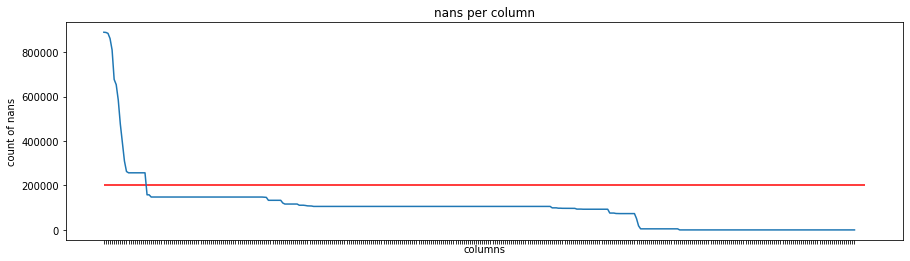

In [19]:
nans_in_col = nans_in_col.sort_values(ascending = False)
plt.figure(figsize = (15,4))
plt.plot(nans_in_col.index, nans_in_col)
#plt.xticks(rotation = 90);
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    labelbottom=False)

plt.hlines(200000, 0, 370, color = 'r')
plt.title("nans per column")
plt.xlabel("columns")
plt.ylabel("count of nans")

In [20]:
# list of columns that have less than 200000 missing values
rel_cols = nans_in_col[nans_in_col < 200000].index.tolist()


## 0.1.2 nans in rows

There are also rows with a lot of nan values. So rows with more than 20 missing values are dropped.

In [21]:
nans_in_rows = nan_azdias.isnull().sum(axis=1)

In [22]:
nans_in_rows.sort_values(ascending = False)

826869    265
537799    265
350182    264
55664     264
373501    264
         ... 
561703      1
554151      1
112523      1
247671      1
46353       1
Length: 891221, dtype: int64

Text(0.5, 0, 'count of nans')

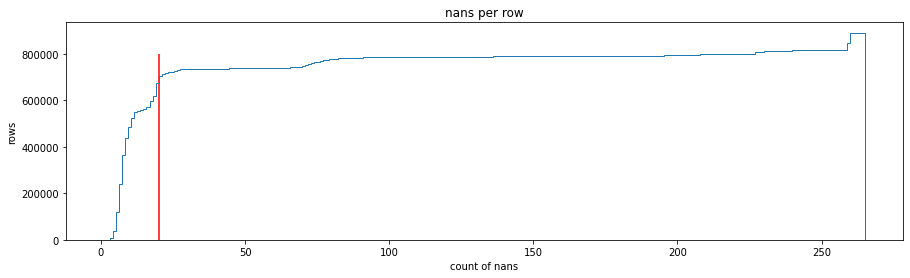

In [23]:
nans_in_rows = nans_in_rows.sort_values(ascending = False)
plt.figure(figsize = (15,4))
plt.hist(nans_in_rows, cumulative = 1, bins = 250, histtype='step');
plt.vlines(20, 0, 800000, color = 'r')
plt.title("nans per row")
plt.ylabel("rows")
plt.xlabel("count of nans")


## 0.1.3 Other columns

Next to missing values there are other columns that need a special treatment.

The CAMEO_DEU_2015 is no numeric column. The values of the column have on the first digit an integer and on the second digit a letter. The integer is coming from the CAMEO_DEUG_2015 column, where we have a clear ranking from "upper class" = 1 to "urban working class" = 9. The letter gives then a subclassification. As there is kind of a ranking, the letter is replaced by an integer. So instead of 1A we have 11 and instead of 1B we have 12. As there are no 1H - 18 and 1I - 19 there is also stronger separation of the classification by the first digit, which is quite reasonable.

In [24]:
nan_azdias['CAMEO_DEU_2015'].value_counts()

6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
Name: CAMEO_DEU_2015, dtype: int64

LNR
The column "LNR" is short for "laufende Nummer" which is in englisch a sequence number. This has no benefit for the analysis and can be dropped

In [ ]:
nan_azdias['LNR'].head()

In [26]:
del_cols = ["LNR"]
rel_cols = list(set(rel_cols) - set(del_cols))

EINGEFUEGT_AM
The column "EINGEFUEGT_AM" is a date column. This column can be reduced to the year.

In [ ]:
nan_azdias['EINGEFUEGT_AM'].head()

'OST_WEST_KZ'
The column 'OST_WEST_KZ' has only two values "O" and "W", which describes if a person is from east or west germany. So the "O" is replaced by a 0 and the "W" is replaced by a 1.

In [ ]:
nan_azdias['OST_WEST_KZ'].value_counts()

In [27]:
azdias_clean = clean_dataframe(nan_azdias, rel_cols, missing_keys_dict, test_df = False)


Old shape: (891221, 366)
New shape: (734818, 344)


In [28]:
customers_clean = clean_dataframe(nan_customers, rel_cols,missing_keys_dict, test_df = False)

Old shape: (191652, 369)
New shape: (132903, 344)


# 0.2 Impute the missing values

In data cleaning we converted all columns to numeric columns. But still there is a difference in the columns. Firstly we have attributive columns, where an integer stands for a group, and secondly we have real numbers. For imputing missing values for attributive columns we should use the mode and for the numeric columns the median.

##### Numerical columns

We find numeric columns in the excel-sheet. But there are also other columns that have numeric values f.e. the date columns. These columns are added to columns we find as numeric columns in the excel-sheet.


In [99]:
attr_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', usecols='B:E', dtype='str', engine = 'openpyxl', skiprows = 1)

In [104]:
attr_values = attr_values[attr_values['Meaning'].notna()]
num_cols = attr_values[attr_values['Meaning'].str.contains("numeric")]['Attribute'].tolist()
num_cols

['ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'GEBURTSJAHR',
 'KBA13_ANZAHL_PKW',
 'MIN_GEBAEUDEJAHR']

In [110]:
num_cols = num_cols + [x for x in cols if "AM_" in x or "_AM" in x or "VK_" in x or "DICHTE" in x]
num_cols

['ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'GEBURTSJAHR',
 'KBA13_ANZAHL_PKW',
 'MIN_GEBAEUDEJAHR',
 'EINGEZOGENAM_HH_JAHR',
 'VK_DHT4A',
 'EINGEFUEGT_AM',
 'VK_DISTANZ',
 'VK_ZG11',
 'EWDICHTE',
 'FIRMENDICHTE']

In [35]:
# Transform-impute Pipeline
num_pipeline = Pipeline([
    ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('num_scale', StandardScaler())
])

##### Attributive columns

Other columns are handled as attributive columns.

In [ ]:
attr_cols = list(set(cols) - set(num_cols))

In [32]:
attr_pipeline = Pipeline([
    ('attr_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('num_scale', StandardScaler())
])

##### Combine pipelines

In [36]:
scalers = [('attr', attr_pipeline, attr_cols),
               ('num', num_pipeline, num_cols),
]
column_transformer = ColumnTransformer(transformers = scalers)

##### Fit column_transformer pipeline to the data

In [37]:
azdias_scaled = column_transformer.fit_transform(azdias_clean)

In [38]:
customers_scaled = column_transformer.fit_transform(customers_clean)

In [39]:
final_cols = attr_cols + num_cols

In [40]:
azdias_scaled = pd.DataFrame(azdias_scaled, columns=final_cols)

In [41]:
customers_scaled = pd.DataFrame(customers_scaled, columns=final_cols)

In [42]:
azdias = None
customers = None
nan_customers = None
nan_azdias = None
# customers_clean = None
# azdias_clean = None

In [43]:
azdias_scaled.shape

(734818, 344)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [45]:
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


%matplotlib inline

## Reduce Dataset with PCA

As we have a lot of data columns

In [46]:

pca = PCA().fit(azdias_scaled)

216 features contain 95 % of the variance of the data


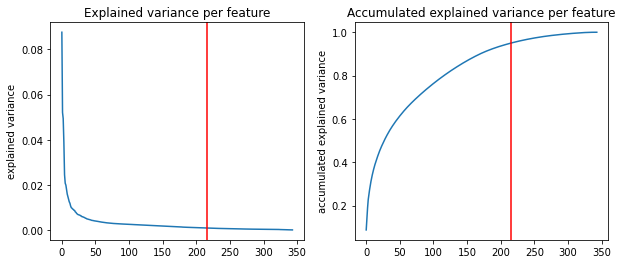

In [47]:

f, (ax1, ax2) = plt.subplots(1, 2,  figsize = (10,4))

values = pca.explained_variance_ratio_ 
acc_values = np.add.accumulate(values)
pca_n_comp = len(acc_values[np.where(acc_values < 0.95)])

ax1.plot( values)
ax1.set_ylabel("explained variance")
ax1.set_title("Explained variance per feature")
ax1.axvline(pca_n_comp, color = 'r')


ax2.plot(acc_values)
ax2.set_ylabel("accumulated explained variance")
ax2.axvline(pca_n_comp, color = 'r')
ax2.set_title("Accumulated explained variance per feature");

print(f"{pca_n_comp} features contain 95 % of the variance of the data")

In [48]:
pca = PCA(n_components=pca_n_comp, random_state = SEED).fit(azdias_scaled)
azdias_reduced = pd.DataFrame(pca.transform(azdias_scaled))

In [49]:
def pca_dimension_features(df, pca, attributes_desc, dimension, n_features = 3):
    
    features = df.columns.values
    feature_weights = dict(zip(features, pca.components_[dimension]))
    feature_weights = {k: v for k, v in sorted(feature_weights.items(), key=lambda item: item[1])}

    top_features = list(feature_weights.keys())[-n_features:]

    top_values = list(feature_weights.values())[-n_features:]

    
    last_features = list(feature_weights.keys())[:n_features]
    
    last_values = list(feature_weights.values())[:n_features]
    
    feature_names = top_features + last_features
    feature_values = top_values + last_values
    
    feature_descs = []

    for feature in feature_names:
        if feature in attributes_desc.Attribute.values:
            feature_descs.append(attributes_desc[attributes_desc.Attribute == feature].Description.values[0])
        else:
            feature_descs.append("No description given")
        

    dimension_features = {"Feature":feature_names, "Description":feature_descs, "FeatureWeight":feature_values}
    dimension_features = pd.DataFrame(dimension_features)
    dimension_features.sort_values("FeatureWeight", inplace=True, ascending=False, ignore_index=True)
    
    return dimension_features
    
#     print(f"Dimension {dimension}:")
#     print(f"top features: {top_features}")
#     print(f"top values: {top_values}")
#     print("")
    
#     print(f"last features: {last_features}")
#     print(f"last values: {last_values}")
    

In [50]:
attributes_desc.head()

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,NaN,ANREDE_KZ,gender,NaN
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [51]:
pca_dimension_features(azdias_scaled,pca,attributes_desc, 0, n_features = 5)

,Feature,Description,FeatureWeight
0,MOBI_REGIO,moving patterns,0.139909
1,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,0.133536
2,KBA13_ANTG1,No description given,0.132913
3,LP_STATUS_FEIN,social status fine,0.129773
4,KBA05_ANTG1,number of 1-2 family houses in the cell,0.129602
5,CAMEO_DEUG_2015,CAMEO_4.0: uppergroup,-0.127509
6,KBA13_ANTG4,No description given,-0.127853
7,CAMEO_DEU_2015,CAMEO_4.0: specific group,-0.128301
8,KBA13_ANTG3,No description given,-0.131749
9,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-0.132416


In [52]:
pca_dimension_features(azdias_scaled,pca,attributes_desc, 1, n_features = 5)

,Feature,Description,FeatureWeight
0,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8,0.173273
1,KBA13_MERCEDES,share of MERCEDES within the PLZ8,0.149648
2,KBA13_SEG_OBEREMITTELKLASSE,share of upper middle class cars and upper cla...,0.147207
3,KBA13_BMW,share of BMW within the PLZ8,0.142868
4,KBA13_SITZE_4,number of cars with less than 5 seats in the PLZ8,0.135972
5,KBA13_HALTER_25,share of car owners between 21 and 25 within t...,-0.117055
6,KBA13_KMH_180,share of cars with max speed between 110 km/h ...,-0.117449
7,KBA13_KMH_140_210,share of cars with max speed between 140 and 2...,-0.125036
8,KBA13_SEG_KLEINWAGEN,share of small and very small cars (Ford Fiest...,-0.126539
9,KBA13_SITZE_5,number of cars with 5 seats in the PLZ8,-0.142531


In [53]:
pca_dimension_features(azdias_scaled,pca,attributes_desc, 2, n_features = 5)

,Feature,Description,FeatureWeight
0,ONLINE_AFFINITAET,online affinity,0.163097
1,CJT_TYP_2,No description given,0.156923
2,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,0.153298
3,CJT_TYP_1,No description given,0.150404
4,FINANZ_SPARER,financial typology: money saver,0.143243
5,D19_GESAMT_ONLINE_DATUM,actuality of the last transaction with the com...,-0.135065
6,CJT_TYP_4,No description given,-0.139040
7,CJT_TYP_6,No description given,-0.140471
8,CJT_TYP_3,No description given,-0.142989
9,CJT_TYP_5,No description given,-0.143726


## Find clusters with K-Means

#### Find k with Ellbow method

https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

In [ ]:

Sum_of_squared_distances = []
K = range(1,17)

for k in K:
    start = time.time()
    km = KMeans(n_clusters=k, random_state = 42)
    km = km.fit(azdias_reduced)
    Sum_of_squared_distances.append(km.inertia_)
    print(f"{k} - {km.inertia_}")
    print(f"time: {time.time()-start}")
          
    

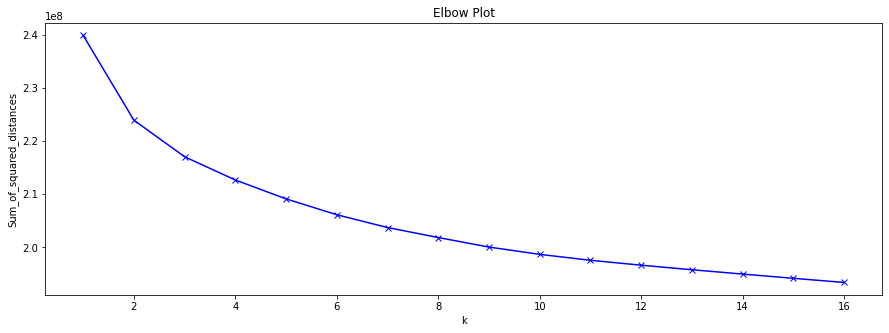

<Figure size 432x288 with 0 Axes>

In [55]:
plt.figure(figsize=(15, 5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Plot')
plt.show()
#plt.xticks(list(range(1,31)))
plt.savefig('elbow_plot.png', dpi=500);

## Combined pipeline

In [54]:
pca_n_comp = 216
#first estimation
kmeans_clusters = 9

In [55]:
cluster_pipeline = Pipeline([
    ('transform', column_transformer),
    ('pca', PCA(n_components = pca_n_comp)),
    ('cluster', KMeans(n_clusters = kmeans_clusters, random_state = SEED))
])

## Compare clusters of population and customers

In [56]:
# Fit cluster pipeline and create clustered general population dataframe
cluster_pipeline.fit(azdias_clean)
azdias_clustered = pd.DataFrame(cluster_pipeline.predict(azdias_clean), columns = ['Cluster'])

In [57]:
azdias_clustered.to_csv('clustered_azdias.csv', index = False)

In [58]:
# Create clustered customers dataframe
customers_clustered = pd.DataFrame(cluster_pipeline.predict(customers_clean), columns = ['Cluster'])

In [59]:
customers_clustered.to_csv('clustered_population.csv', index = False)

In [60]:
azdias_clustered = pd.read_csv('clustered_azdias.csv')
customers_clustered = pd.read_csv('clustered_population.csv')

In [61]:
population_clusters = azdias_clustered['Cluster'].value_counts().sort_index()
customer_clusters = customers_clustered['Cluster'].value_counts().sort_index()

In [62]:
population_clusters

0     59282
1     66210
2     87507
3     53956
4     47049
5     95336
6    104518
7    108823
8    112137
Name: Cluster, dtype: int64

In [63]:
population_clusters.tolist()

[59282, 66210, 87507, 53956, 47049, 95336, 104518, 108823, 112137]

<Figure size 1080x360 with 0 Axes>

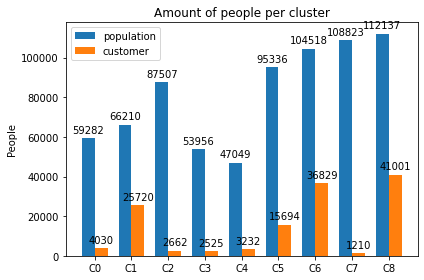

In [64]:

labels = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

plt.figure(figsize=(15, 5))
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, population_clusters.tolist(), width, label='population')
rects2 = ax.bar(x + width/2, customer_clusters.tolist(), width, label='customer')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('People')
ax.set_title('Amount of people per cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [65]:
population_clusters_perc = (population_clusters / population_clusters.sum())*100
population_clusters_perc = [round(num,1) for num in population_clusters_perc]
customer_clusters_perc = (customer_clusters / customer_clusters.sum())*100
customer_clusters_perc = [round(num, 1) for num in customer_clusters_perc]

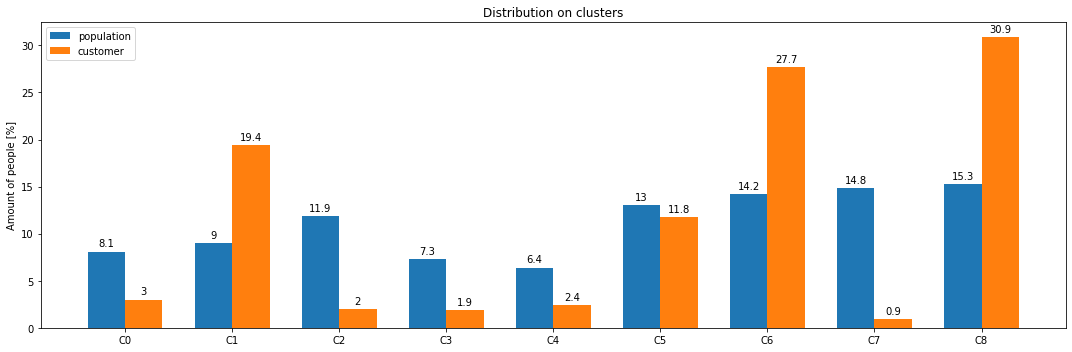

In [66]:
labels = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


fig, ax = plt.subplots(figsize=(15, 5))
rects1 = ax.bar(x - width/2, population_clusters_perc, width, label='population')
rects2 = ax.bar(x + width/2, customer_clusters_perc, width, label='customer')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Amount of people [%]')
ax.set_title('Distribution on clusters')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

### What do the cluster represent?

In [67]:
def get_clusters_centers_df(cluster_pipeline, final_cols):
    kmeans = cluster_pipeline.named_steps['cluster']
    pca_components = cluster_pipeline.named_steps['pca']
    
    cluster_centers = pca_components.inverse_transform(kmeans.cluster_centers_)
    cluster_centers_df = pd.DataFrame(cluster_centers, columns=final_cols)
    return cluster_centers_df

In [68]:
def get_top_cluster_features(cluster_centers_df, cluster, attributes_desc, n_features = 5):
    top_features = cluster_centers_df.iloc[cluster].sort_values(ascending=False).head(n_features).index.tolist()
    top_values = cluster_centers_df.iloc[cluster].sort_values(ascending=False).head(n_features).values.tolist()
    
    last_features = cluster_centers_df.iloc[cluster].sort_values(ascending=False).tail(n_features).index.tolist()
    last_values = cluster_centers_df.iloc[cluster].sort_values(ascending=False).tail(n_features).values.tolist()
    
    feature_names = top_features + last_features
    feature_values = top_values + last_values
    
    feature_descs = []
    for feature in feature_names:
        if feature in attributes_desc.Attribute.values:
            feature_descs.append(attributes_desc[attributes_desc.Attribute == feature].Description.values[0])
        else:
            feature_descs.append("No description given")
    
    cluster_features = {"Feature":feature_names, "Description":feature_descs, "FeatureWeight":feature_values}
    cluster_features = pd.DataFrame(cluster_features)
    cluster_features.sort_values("FeatureWeight", inplace=True, ascending=False, ignore_index=True)
    
    return cluster_features

In [69]:
cluster_centers_df =  get_clusters_centers_df(cluster_pipeline, final_cols)

###### Cluster 1

In [77]:
get_top_cluster_features(cluster_centers_df, 1, attributes_desc, 5)

,Feature,Description,FeatureWeight
0,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8,1.243894
1,KBA13_SEG_SPORTWAGEN,share of sportscars within the PLZ8,1.133725
2,KBA13_KW_121,share of cars with an engine power of more tha...,1.125827
3,KBA13_KMH_211,share of cars with a greater max speed than 21...,1.112219
4,KBA05_KW3,share of cars with an engine power of more tha...,1.110325
5,KKK,purchasing power,-0.956135
6,KBA13_KW_0_60,share of cars with less than 61 KW engine powe...,-0.957586
7,KBA13_HERST_FORD_OPEL,share of Ford & Opel/Vauxhall within the PLZ8,-1.011984
8,KBA13_KMH_180,share of cars with max speed between 110 km/h ...,-1.046401
9,KBA13_KMH_140_210,share of cars with max speed between 140 and 2...,-1.119319


###### Cluster 6

In [78]:
get_top_cluster_features(cluster_centers_df, 6, attributes_desc, 5)

,Feature,Description,FeatureWeight
0,D19_GESAMT_ANZ_24,No description given,1.307598
1,D19_VERSAND_ANZ_24,No description given,1.279743
2,D19_GESAMT_ANZ_12,No description given,1.275550
3,D19_VERSAND_ANZ_12,No description given,1.221939
4,LP_LEBENSPHASE_FEIN,lifestage fine,1.130469
5,VK_DHT4A,No description given,-1.169546
6,D19_GESAMT_ONLINE_DATUM,actuality of the last transaction with the com...,-1.176607
7,D19_VERSAND_ONLINE_DATUM,actuality of the last transaction for the segm...,-1.179571
8,D19_GESAMT_DATUM,actuality of the last transaction with the com...,-1.193253
9,D19_VERSAND_DATUM,actuality of the last transaction for the segm...,-1.226282


###### Cluster 8

In [111]:
get_top_cluster_features(cluster_centers_df, 8, attributes_desc, 5)

,Feature,Description,FeatureWeight
0,FINANZ_MINIMALIST,financial typology: low financial interest,0.980937
1,LP_STATUS_GROB,social status rough,0.901833
2,LP_STATUS_FEIN,social status fine,0.895377
3,CJT_TYP_5,No description given,0.839977
4,MOBI_REGIO,moving patterns,0.816808
5,KBA13_ANTG3,No description given,-0.778633
6,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,-0.790732
7,CJT_TYP_1,No description given,-0.824338
8,FINANZ_SPARER,financial typology: money saver,-0.864089
9,CJT_TYP_2,No description given,-0.934118


In [73]:
cluster_centers_df.iloc[0].sort_values(ascending=False).tail(5)

VK_DHT4A                   -1.171327
D19_GESAMT_ONLINE_DATUM    -1.178037
D19_VERSAND_ONLINE_DATUM   -1.179707
D19_GESAMT_DATUM           -1.195155
D19_VERSAND_DATUM          -1.225899
Name: 0, dtype: float64

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### Cleaning the data

In [74]:
with open("final_cols.txt", 'rb') as fp:
    final_col = pickle.load(fp)

In [75]:
final_col = azdias_clean.columns.tolist()

In [76]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv')

c:\users\kirchjna\anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:3170: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [77]:
df_mailout = mailout_train.drop(['RESPONSE'], axis = 1)
df_mailout_clean = clean_dataframe(df_mailout, final_cols, missing_keys_dict, test_df = False)
df_mailout_clean = pd.DataFrame(df_mailout_clean, columns=final_cols)

Old shape: (42962, 366)
New shape: (33538, 344)


In [78]:
df_mailout_clean = pd.merge(df_mailout_clean, mailout_train['RESPONSE'], left_index = True, right_index = True)

### Selecting the Evaluation Metric

In [79]:
df_mailout_clean['RESPONSE'].value_counts()

0    33123
1      415
Name: RESPONSE, dtype: int64

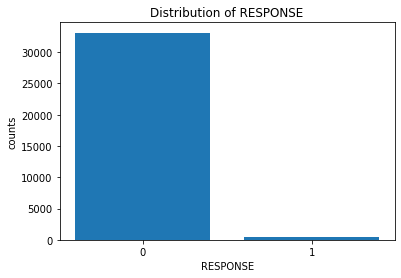

In [80]:
plt.bar(df_mailout_clean['RESPONSE'].value_counts().index,df_mailout_clean['RESPONSE'].value_counts())
plt.xticks([0,1])
plt.xlabel("RESPONSE")
plt.ylabel("counts")
plt.title("Distribution of RESPONSE");

The data is extremly imbalanced. We have way more 0 than 1 Responses.That's why we have to choose a evaluation metric that is good for imbalanced data and classification. Two typical evaluation metrics are the Precision-Recall AUC and the ROC AUC. Here it depends where the stakeholder wants to put his focus.

The Precision-Recall AUC focuses more on finding true positives. But also have more false postives.
The ROC AUC better distinguishes between the classes. So both classes 

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/

### Test different models

In [96]:
def train_and_predict(model, X, y, SEED):
    """
    INPUT: model, X, y, SEED
    OUTPUT: ROC AUC score, time for training and prediction
    
    model is fitted to the data, test data is predicted and scored with roc_auc_score  
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
    
    start = time.time()
    model = model.fit(X_train, y_train)
    
    roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    
    end = time.time()
    time_needed = end - start
    
    return roc_score, time_needed

In [87]:
models = [("LogisticRegression", LogisticRegression(random_state=SEED)),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=SEED)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=SEED)),
         ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=SEED)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=SEED)),
          ("XGBClassifier",xgb.XGBClassifier(random_state=SEED))]

#### 1.Original dataset

In [94]:
X = df_mailout_clean.drop(['RESPONSE'], axis = 1)
X = column_transformer.fit_transform(X)

y = df_mailout_clean['RESPONSE']

In [97]:
for name, model in models:
    roc_score, time_needed = train_and_predict(model, X, y, SEED)
    
    print( f"Model: {model}   -  ROC AUC: {roc_score}  -  Time: {time_needed}")

c:\users\kirchjna\anaconda3\envs\capstone\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model: LogisticRegression(random_state=42)   -  ROC AUC: 0.6578794508147254  -  Time: 1.837076187133789
Model: DecisionTreeClassifier(random_state=42)   -  ROC AUC: 0.5034474954737477  -  Time: 3.4923250675201416
Model: RandomForestClassifier(random_state=42)   -  ROC AUC: 0.5598266822570911  -  Time: 10.36422324180603
Model: GradientBoostingClassifier(random_state=42)   -  ROC AUC: 0.7195345503922752  -  Time: 90.3607485294342
Model: AdaBoostClassifier(random_state=42)   -  ROC AUC: 0.6901780325890163  -  Time: 22.252197980880737
Model: XGBClassifier(random_state=42)   -  ROC AUC: 0.705390012070006  -  Time: 17.467575788497925


#### 2. PCA reduced dataset

In [111]:
X_pca = df_mailout_clean.drop(['RESPONSE'], axis = 1)
X_pca = column_transformer.fit_transform(X_pca)
X_pca = pca.transform(X_pca)

y_pca = df_mailout_clean['RESPONSE']

In [112]:
for name, model in models:
    roc_score, time_needed = train_and_predict(model, X_pca, y_pca, SEED)
    
    print( f"Model: {model}   -  ROC AUC: {roc_score}  -  Time: {time_needed}")

Model: LogisticRegression(random_state=42)   -  ROC AUC: 0.6575682709716355  -  Time: 0.5566983222961426
Model: DecisionTreeClassifier(random_state=42)   -  ROC AUC: 0.4984799336149668  -  Time: 57.02929639816284
Model: RandomForestClassifier(random_state=42)   -  ROC AUC: 0.4339987552806276  -  Time: 115.96275019645691
Model: GradientBoostingClassifier(random_state=42)   -  ROC AUC: 0.5492625980687991  -  Time: 259.75930523872375
Model: AdaBoostClassifier(random_state=42)   -  ROC AUC: 0.5852793074834037  -  Time: 53.39734673500061
Model: XGBClassifier(random_state=42)   -  ROC AUC: 0.6153081623415811  -  Time: 36.26136636734009


#### 3. Cluster only

In [103]:
X_clu = df_mailout_clean.drop(['RESPONSE'], axis = 1)
X_clu = pd.DataFrame(cluster_pipeline.predict(X_clu), columns = ['Cluster'])
X_clu = pd.get_dummies(mailout_clustered['Cluster'], prefix = 'Cluster')

y_clu = df_mailout_clean['RESPONSE']

In [104]:
for name, model in models:
    roc_score, time_needed = train_and_predict(model, X_clu, y_clu, SEED)
    
    print( f"Model: {model}   -  ROC AUC: {roc_score}  -  Time: {time_needed}")

Model: LogisticRegression(random_state=42)   -  ROC AUC: 0.5934416490645745  -  Time: 0.09176015853881836
Model: DecisionTreeClassifier(random_state=42)   -  ROC AUC: 0.5889512296318647  -  Time: 0.025911331176757812
Model: RandomForestClassifier(random_state=42)   -  ROC AUC: 0.5772716128545564  -  Time: 0.7801105976104736
Model: GradientBoostingClassifier(random_state=42)   -  ROC AUC: 0.5889512296318647  -  Time: 1.1181912422180176
Model: AdaBoostClassifier(random_state=42)   -  ROC AUC: 0.5889512296318647  -  Time: 0.5703914165496826
Model: XGBClassifier(random_state=42)   -  ROC AUC: 0.5934416490645745  -  Time: 0.8171005249023438


#### 4. Cluster plus original dataset

In [109]:
X = df_mailout_clean.drop(['RESPONSE'], axis = 1)
X_clu = pd.DataFrame(cluster_pipeline.predict(X), columns = ['Cluster'])
X_clu = pd.get_dummies(mailout_clustered['Cluster'], prefix = 'Cluster')

X = column_transformer.fit_transform(X)

X_all = np.concatenate((X, X_clu), axis = 1)


y_all = df_mailout_clean['RESPONSE']

In [110]:
for name, model in models:
    roc_score, time_needed = train_and_predict(model, X_all, y_all, SEED)
    
    print( f"Model: {model}   -  ROC AUC: {roc_score}  -  Time: {time_needed}")

c:\users\kirchjna\anaconda3\envs\capstone\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model: LogisticRegression(random_state=42)   -  ROC AUC: 0.6608026554013278  -  Time: 2.016834259033203
Model: DecisionTreeClassifier(random_state=42)   -  ROC AUC: 0.510602745926373  -  Time: 3.608574390411377
Model: RandomForestClassifier(random_state=42)   -  ROC AUC: 0.5222371001810501  -  Time: 11.18921947479248
Model: GradientBoostingClassifier(random_state=42)   -  ROC AUC: 0.7118682106216054  -  Time: 85.74704647064209
Model: AdaBoostClassifier(random_state=42)   -  ROC AUC: 0.6901780325890163  -  Time: 20.53794240951538
Model: XGBClassifier(random_state=42)   -  ROC AUC: 0.705390012070006  -  Time: 19.115639686584473


Summary:
Overall the XGBClassifier (XGB) and the GradienBoostingClassifier (GBC) get the highest score on the original dataset and on the cluster + original dataset. There is nearly no differenc in the score but in the time the original dataset with out the cluster columns is faster. So for further investigations we take those two models on the original dataset.

Useing just the cluster columns improves for all modells the processing time and for some modells also the score. But for XGB and GBC the score decreases. 



### Optimize chosen models with GridSearch

#### 1. GradientBoostingClassifier

In [113]:
param_grid = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    }

GBC_grid = GridSearchCV(estimator = GradientBoostingClassifier(random_state=SEED), 
                             param_grid = param_grid, 
                             scoring = "roc_auc", 
                             cv = 5, 
                             n_jobs = -1,
                             verbose = 2
                            )

In [ ]:
%%time
X = df_mailout_clean.drop(['RESPONSE'], axis = 1)
X = column_transformer.fit_transform(X)

y = df_mailout_clean['RESPONSE']

GBC_grid.fit(X, y)


GBC_result = GBC_grid.best_estimator_


print("GBCClassifier")
print(f"Best score: {GBC_grid.best_score_}")
print(f"Best parmeter:{GBC_grid.best_params_}")

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 13.2min


##### 2. XGBoost

In [81]:
xgb_param_grid = {"max_depth": [5,10,20,30],
              "learning_rate": [0.01,0.1,0.5,0.9,1.],
              "gamma":[0.1,0.5,1.0],
              "n_estimators":[50,100,150,200]
              }

xgb_grid = GridSearchCV(estimator = xgb.XGBClassifier(objective="binary:logistic", 
                                                            n_jobs=1, eval_metric="auc",
                                                            silent=1,random_state=SEED), 
                           param_grid = xgb_param_grid, 
                           scoring = "roc_auc",
                           cv = 5, n_jobs = -1, verbose=2)

In [82]:
%%time
X = df_mailout_clean.drop(['RESPONSE'], axis = 1)
X = column_transformer.fit_transform(X)

y = df_mailout_clean['RESPONSE']

xgb_grid.fit(X, y)

xgb_result = xgb_grid.best_estimator_

print("XGBClassifier")
print(f"Best score: {xgb_grid.best_score_}")
print(f"Best parmeter:{xgb_grid.best_params_}")

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 82.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 177.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 335.6min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 533.9min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 657.1min finished


AdaBoostClassifier
Best score: 0.7214763641110793
Best parmeter:{'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Wall time: 10h 57min 48s


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

### 3.1 Clean test dataframe

In [ ]:
mailout_test_LNR = mailout_test["LNR"]
mailout_test = clean_dataframe(mailout_test, final_cols, missing_keys_dict, test_df = True)

### 3.2 Fit the modell

In [ ]:
X_test = column_transformer.fit_transform(mailout_test)

In [ ]:
y_test_preds_xgb = result_xgb.predict_proba(X_test)[:,1]

In [ ]:
df_kaggle = pd.DataFrame(index=mailout_test_LNR, data =y_test_preds_xgb, columns = ["RESPONSE"])

In [ ]:
df_kaggle.head()

In [ ]:
df_kaggle.to_csv("submission.csv")